# 支持向量机SVM（下）

## 1 二分类SVC的进阶

### 1.1 SVC用于二分类的原理复习

![image.png](./images/215.png)

![image.png](./images/216.png)

![image.png](./images/217.png)

### 1.2 参数C的理解进阶

![image.png](./images/218.png)

![image.png](./images/219.png)

![image.png](./images/220.png)

e:\python\python37\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
e:\python\python37\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
e:\python\python37\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass 

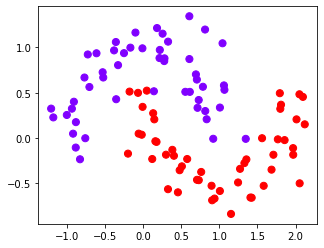

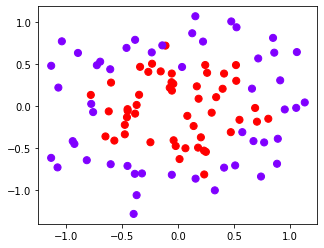

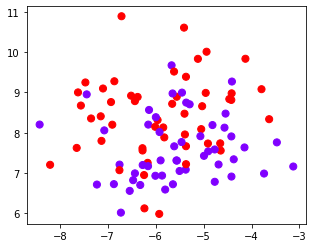

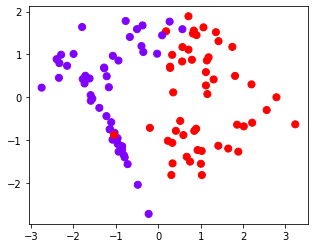

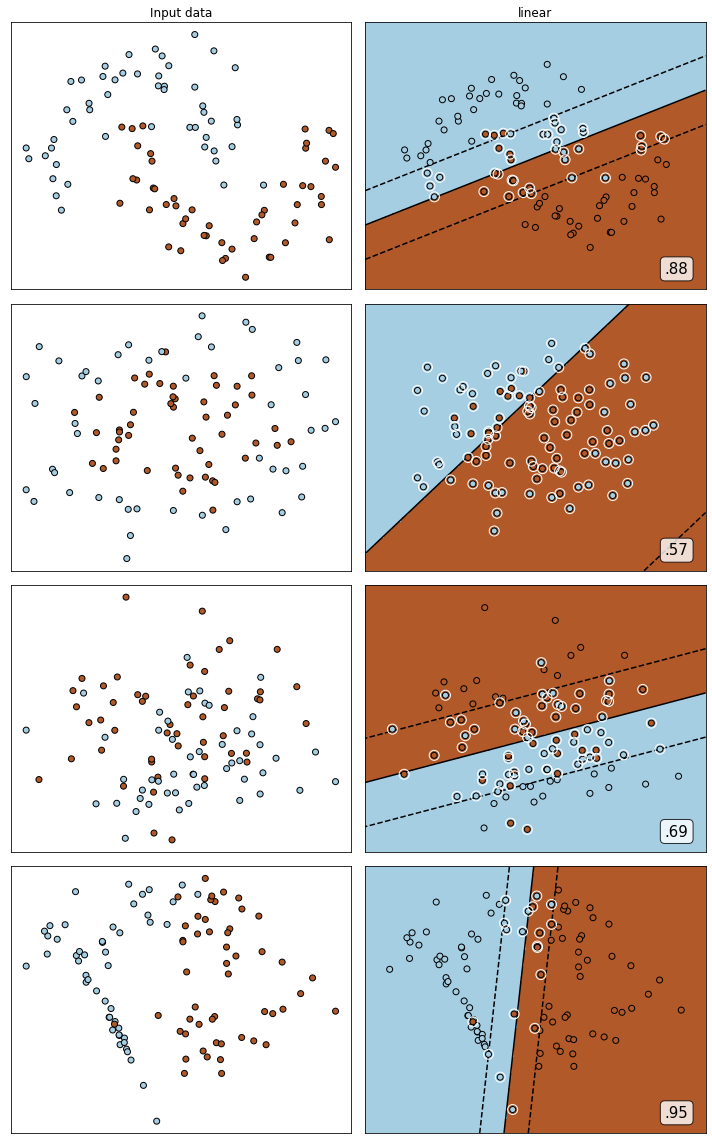

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.datasets import make_circles, make_moons, make_blobs,make_classification

n_samples = 100

datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samples, centers=2, random_state=5),
    make_classification(n_samples=n_samples,n_features =2,n_informative=2,n_redundant=0, random_state=5)
]

Kernel = ["linear"]

#四个数据集分别是什么样子呢？
for X,Y in datasets:
    plt.figure(figsize=(5,4))
    plt.scatter(X[:,0],X[:,1],c=Y,s=50,cmap="rainbow")
    
nrows=len(datasets)
ncols=len(Kernel) + 1
fig, axes = plt.subplots(nrows, ncols,figsize=(10,16))

    
#第一层循环：在不同的数据集中循环
for ds_cnt, (X,Y) in enumerate(datasets):

    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())

    for est_idx, kernel in enumerate(Kernel):
        ax = axes[ds_cnt, est_idx + 1]

        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, Y)
        score = clf.score(X, Y)

        ax.scatter(X[:, 0], X[:, 1], c=Y
                   ,zorder=10
                   ,cmap=plt.cm.Paired,edgecolors='k')
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                    facecolors='none', zorder=10, edgecolors='white')

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-1, 0, 1])
        ax.set_xticks(())
        ax.set_yticks(())

        if ds_cnt == 0:
            ax.set_title(kernel)

        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0')
               , size=15
               , bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')
               #为分数添加一个白色的格子作为底色
               , transform=ax.transAxes #确定文字所对应的坐标轴，就是ax子图的坐标轴本身
               , horizontalalignment='right' #位于坐标轴的什么方向
               )
plt.tight_layout()
plt.show()

白色圈圈出的就是我们的支持向量，大家可以看到，所有在两条虚线超平面之间的点，和虚线超平面外，但属于另
一个类别的点，都被我们认为是支持向量。并不是因为这些点都在我们的超平面上，而是因为我们的超平面由所有
的这些点来决定，我们可以通过调节C来移动我们的超平面，让超平面过任何一个白色圈圈出的点。参数C就是这样
影响了我们的决策，可以说是彻底改变了支持向量机的决策过程。

### 1.3 二分类SVC中的样本不均衡问题：重要参数class_weight

对于分类问题，永远都逃不过的一个痛点就是样本不均衡问题。样本不均衡是指在一组数据集中，标签的一类天生
占有很大的比例，但我们有着捕捉出某种特定的分类的需求的状况。比如，我们现在要对潜在犯罪者和普通人进行
分类，潜在犯罪者占总人口的比例是相当低的，也许只有2%左右，98%的人都是普通人，而我们的目标是要捕获
出潜在犯罪者。这样的标签分布会带来许多问题。

![image.png](./images/221.png)

![image.png](./images/222.png)

我们接下来就来看看如何使用这个参数。<br>
<br>
首先，我们来自建一组样本不平衡的数据集。我们在这组数据集上建两个SVC模型，一个设置有class_weight参
数，一个不设置class_weight参数。我们对两个模型分别进行评估并画出他们的决策边界，以此来观察
class_weight带来的效果。

**1. 导入需要的库和模块**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

**2. 创建样本不均衡的数据集**

In [10]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [11]:
X.shape

(550, 2)

In [12]:
y.shape

(550,)

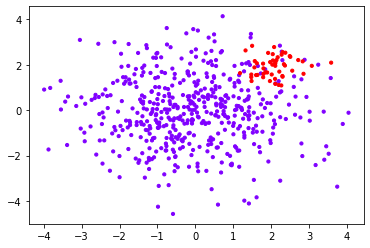

In [13]:
#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10)
#其中红色点是少数类，紫色点是多数类

**3. 在数据集上分别建模**

In [14]:
#不设定class_weight
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)

SVC(kernel='linear')

In [15]:
#设定class_weight
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)

SVC(class_weight={1: 10}, kernel='linear')

In [16]:
#给两个模型分别打分看看，这个分数是accuracy准确度
clf.score(X,y)

0.9418181818181818

In [17]:
wclf.score(X,y)

0.9127272727272727

**4. 绘制两个模型下数据的决策边界**

![image.png](./images/223.png)

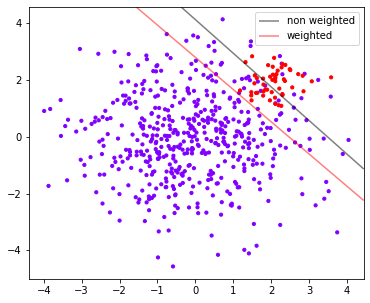

In [24]:
#首先要有数据分布
plt.figure(figsize=(6,5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10)
ax = plt.gca() #获取当前的子图，如果不存在，则创建新的子图

#绘制决策边界的第一步：要有网格
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

#第二步：找出我们的样本点到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z_clf, colors='black', levels=[0], alpha=0.5, linestyles=['-'])

Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf, colors='red', levels=[0], alpha=0.5, linestyles=['-'])

#第三步：画图例
plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],loc="upper right")
plt.show()

In [27]:
a.collections #调用这个等高线对象中画的所有线，返回一个惰性对象

<a list of 1 mcoll.LineCollection objects>

In [28]:
#用[*]把它打开试试看
[*a.collections] #返回了一个linecollection对象，其实就是我们等高线里所有的线的列表

In [29]:
#现在我们只有一条线，所以我们可以使用索引0来锁定这个对象
a.collections[0]

In [30]:
#plt.legend([对象列表],[图例列表],loc)
#只要对象列表和图例列表相对应，就可以显示出图例

从图像上可以看出，灰色是我们做样本平衡之前的决策边界。灰色线上方的点被分为一类，下方的点被分为另一
类。可以看到，大约有一半少数类（红色）被分错，多数类（紫色点）几乎都被分类正确了。红色是我们做样本平
衡之后的决策边界，同样是红色线上方一类，红色线下方一类。可以看到，做了样本平衡后，少数类几乎全部都被
分类正确了，但是多数类有许多被分错了。我们来看看两种情况下模型的准确率如何表现：

In [31]:
#给两个模型分别打分看看，这个分数是accuracy准确度
#做样本均衡之后，我们的准确率下降了，没有样本均衡的准确率更高
clf.score(X,y)

0.9418181818181818

In [32]:
wclf.score(X,y)

0.9127272727272727

可以看出，从准确率的角度来看，不做样本平衡的时候准确率反而更高，做了样本平衡准确率反而变低了，**这是因
为做了样本平衡后，为了要更有效地捕捉出少数类，模型误伤了许多多数类样本，而多数类被分错的样本数量 > 少
数类被分类正确的样本数量，使得模型整体的精确性下降。** 现在，如果我们的目的是模型整体的准确率，那我们就
要拒绝样本平衡，使用class_weight被设置之前的模型。<br>
<br>
然而在现实中，我们往往都在追求捕捉少数类，因为在很多情况下，将少数类判断错的代价是巨大的。比如我们之
前提到的，判断潜在犯罪者和普通人的例子，如果我们没有能够识别出潜在犯罪者，那么这些人就可能去危害社
会，造成恶劣影响，但如果我们把普通人错认为是潜在犯罪者，我们也许只是需要增加一些监控和人为甄别的成
本。所以对我们来说，我们宁愿把普通人判错，也不想放过任何一个潜在犯罪者。我们希望不惜一切代价来捕获少
数类，或者希望捕捉出尽量多的少数类，那我们就必须使用class_weight设置后的模型。

## 2 SVC的模型评估指标

![image.png](./images/224.png)

### 2.1 混淆矩阵（Confusion Matrix）

![image.png](./images/225.png)

#### 2.1.1 模型整体效果：准确率

![image.png](./images/226.png)

#### 2.1.2 捕捉少数类的艺术：精确度，召回率和F1 score

![image.png](./images/227.png)

In [33]:
#所有判断正确并确实为1的样本 / 所有被判断为1的样本
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(clf.predict(X) == 1).sum()

0.7142857142857143

In [34]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(wclf.predict(X) == 1).sum()

0.5102040816326531

![image.png](./images/228.png)

In [35]:
#所有predict为1的点 / 全部为1的点的比例
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(y == 1).sum()

0.6

In [36]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(y == 1).sum()

1.0

![image.png](./images/229.png)

#### 2.1.3 判错多数类的考量：特异度与假正率

![image.png](./images/230.png)

In [37]:
#所有被正确预测为0的样本 / 所有的0样本
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 0).sum()/(y == 0).sum()

0.976

In [38]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 0).sum()/(y == 0).sum()

0.904

![image.png](./images/231.png)

#### 2.1.4 sklearn中的混淆矩阵

sklearn当中提供了大量的类来帮助我们了解和使用混淆矩阵。

![image.png](./images/232.png)

### 2.2 ROC曲线以及其相关问题

![image.png](./images/233.png)

#### 2.2.1 概率(probability)与阈值(threshold)

要理解概率与阈值，最容易的状况是来回忆一下我们用逻辑回归做分类的时候的状况。逻辑回归的predict_proba
接口对每个样本生成每个标签类别下的似然（类概率）。对于这些似然，逻辑回归天然规定，当一个样本所对应的
这个标签类别下的似然大于0.5的时候，这个样本就被分为这一类。比如说，一个样本在标签1下的似然是0.6，在
标签0下的似然是0.4，则这个样本的标签自然就被分为1。逻辑回归的回归值本身，其实也就是标签1下的似然。在
这个过程中，0.5就被称为阈值。来看看下面的例子：

**1.自建数据集**

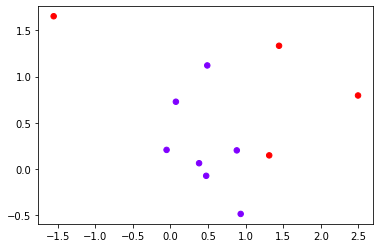

In [64]:
class_1_ = 7
class_2_ = 4
centers_ = [[0.0, 0.0], [1,1]]
clusters_std = [0.5, 1]
X_, y_ = make_blobs(n_samples=[class_1_, class_2_],
                  centers=centers_,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap="rainbow",s=30)
plt.show()

**2. 建模，调用概率**

In [65]:
from sklearn.linear_model import LogisticRegression as LogiR

In [66]:
clf_lo = LogiR().fit(X_,y_)
prob = clf_lo.predict_proba(X_)

In [67]:
prob.shape

(11, 2)

In [68]:
#将样本和概率放到一个DataFrame中
import pandas as pd
prob = pd.DataFrame(prob)

In [69]:
prob.columns = ["0","1"]

In [70]:
prob

,0,1
0,0.694619,0.305381
1,0.510931,0.489069
2,0.820038,0.179962
3,0.785647,0.214353
4,0.777387,0.222613
5,0.656634,0.343366
6,0.768586,0.231414
7,0.349171,0.650829
8,0.366184,0.633816
9,0.663272,0.336728


**3. 使用阈值0.5，大于0.5的样本被预测为1，小于0.5的样本被预测为0**

In [71]:
#手动调节阈值，来改变我们的模型效果
for i in range(prob.shape[0]):
    if prob.loc[i,"1"] > 0.5:
        prob.loc[i,"pred"] = 1
    else:
        prob.loc[i,"pred"] = 0
prob["y_true"] = y_

In [72]:
prob

,0,1,pred,y_true
0,0.694619,0.305381,0.0,0
1,0.510931,0.489069,0.0,0
2,0.820038,0.179962,0.0,0
3,0.785647,0.214353,0.0,0
4,0.777387,0.222613,0.0,0
5,0.656634,0.343366,0.0,0
6,0.768586,0.231414,0.0,0
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
9,0.663272,0.336728,0.0,1


In [73]:
prob = prob.sort_values(by="1",ascending=False)

In [74]:
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,0.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


**4. 使用混淆矩阵查看结果**

In [75]:
from sklearn.metrics import confusion_matrix as CM, precision_score as P, recall_score as R

In [76]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

array([[2, 2],
       [0, 7]], dtype=int64)

![image.png](./images/234.png)

In [77]:
#试试看手动计算Precision和Recall?

In [78]:
2/2  #Precision

1.0

In [79]:
2/4  #Recall

0.5

In [80]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

1.0

In [81]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.5

**5. 假如我们使用0.4作为阈值呢？**

In [82]:
for i in range(prob.shape[0]):
    if prob.loc[i,"1"] > 0.4:
        prob.loc[i,"pred"] = 1
    else:
        prob.loc[i,"pred"] = 0

In [83]:
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [84]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

array([[2, 2],
       [1, 6]], dtype=int64)

In [85]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.6666666666666666

In [86]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
#注意，降低或者升高阈值并不一定能够让模型的效果变好，一切都基于我们要追求怎样的模型效果

0.5

In [92]:
#*****************************************************************

In [87]:
for i in range(prob.shape[0]):
    if prob.loc[i,"1"] > 0.3:
        prob.loc[i,"pred"] = 1
    else:
        prob.loc[i,"pred"] = 0

In [88]:
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,1.0,1
5,0.656634,0.343366,1.0,0
9,0.663272,0.336728,1.0,1
0,0.694619,0.305381,1.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [89]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

array([[4, 0],
       [3, 4]], dtype=int64)

In [90]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.5714285714285714

In [91]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

1.0

![image.png](./images/235.png)

#### 2.2.2 SVM实现概率预测：重要参数probability，接口predict_proba以及decision_function

我们在画等高线，也就是决策边界的时候曾经使用SVC的接口decision_function，它返回我们输入的特征矩阵中每
个样本到划分数据集的超平面的距离。我们在SVM中利用超平面来判断我们的样本，本质上来说，当两个点的距离
是相同的符号的时候，越远离超平面的样本点归属于某个标签类的概率就很大。比如说，一个距离超平面0.1的
点，和一个距离超平面100的点，明显是距离为0.1的点更有可能是负类别的点混入了边界。同理，一个距离超平面
距离为-0.1的点，和一个离超平面距离为-100的点，明显是-100的点的标签更有可能是负类。所以，到超平面的距
离一定程度上反应了样本归属于某个标签类的可能性。接口decision_function返回的值也因此被我们认为是SVM
中的置信度（confidence）。

![image.png](./images/236.png)

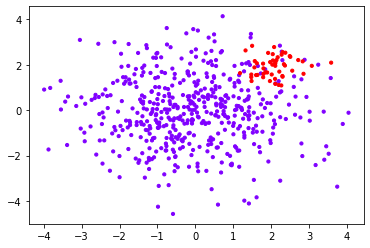

In [119]:
#使用最初的X和y，样本不均衡的这个模型
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)
#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10)

In [94]:
#其中红色点是少数类，紫色点是多数类
clf_proba = svm.SVC(kernel="linear",C=1.0,probability=True).fit(X,y)

In [97]:
clf_proba.predict_proba(X) #生成各类标签下的概率

array([[0.69251479, 0.30748521],
       [0.27593313, 0.72406687],
       [0.96190376, 0.03809624],
       ...,
       [0.16628913, 0.83371087],
       [0.36682443, 0.63317557],
       [0.32888148, 0.67111852]])

In [98]:
clf_proba.predict_proba(X).shape

(550, 2)

In [99]:
clf_proba.decision_function(X) #一列距离

array([ -0.39182241,   0.95617053,  -2.24996184,  -2.63659269,
        -3.65243197,  -1.67311996,  -2.56396417,  -2.80650393,
        -1.76184723,  -4.7948575 ,  -7.59061196,  -3.66174848,
        -2.2508023 ,  -4.27626526,   0.78571364,  -3.24751892,
        -8.57016271,  -4.45823747,  -0.14034183,  -5.20657114,
        -8.02181046,  -4.18420871,  -5.6222409 ,  -5.12602771,
        -7.22592707,  -5.07749638,  -6.72386021,  -3.4945225 ,
        -3.51475144,  -5.72941551,  -5.79160724,  -8.06232013,
        -4.36303857,  -6.25419679,  -5.59426696,  -2.60919281,
        -3.90887478,  -4.38754704,  -6.46432224,  -4.54279979,
        -4.78961735,  -5.53727469,   1.33920817,  -2.27766451,
        -4.39650854,  -2.97649872,  -2.26771979,  -2.40781748,
        -1.41638181,  -3.26142275,  -2.7712218 ,  -4.87288439,
        -3.2594128 ,  -5.91189118,   1.48676267,   0.5389064 ,
        -2.76188843,  -3.36126945,  -2.64697843,  -1.63635284,
        -5.04695135,  -1.59196902,  -5.5195418 ,  -2.10

In [100]:
clf_proba.decision_function(X).shape

(550,)

值得注意的是，在二分类过程中，decision_function只会生成一列距离，样本的类别由距离的符号来判断，但是
predict_proba会生成两个类别分别对应的概率。SVM也可以生成概率，所以我们可以使用和逻辑回归同样的方式
来在SVM上设定和调节我们的阈值。<br>
<br>
毋庸置疑，Platt缩放中涉及的交叉验证对于大型数据集来说非常昂贵，计算会非常缓慢。另外，由于Platt缩放的理
论原因，在二分类过程中，有可能出现predict_proba返回的概率小于0.5，但样本依旧被标记为正类的情况出现，
毕竟支持向量机本身并不依赖于概率来完成自己的分类。如果我们的确需要置信度分数，但不一定非要是概率形式
的话，那建议可以将probability设置为False，使用decision_function这个接口而不是predict_proba。

#### 2.2.3 绘制SVM的ROC曲线

现在，我们理解了什么是阈值（threshold），了解了不同阈值会让混淆矩阵产生变化，也了解了如何从我们的分
类算法中获取概率。现在，我们就可以开始画我们的ROC曲线了。ROC是一条以不同阈值下的假正率FPR为横坐
标，不同阈值下的召回率Recall为纵坐标的曲线。简单地来说，只要我们有数据和模型，我们就可以在python中绘
制出我们的ROC曲线。思考一下，我们要绘制ROC曲线，就必须在我们的数据中去不断调节阈值，不断求解混淆矩
阵，然后不断获得我们的横坐标和纵坐标，最后才能够将曲线绘制出来。接下来，我们就来执行这个过程：

In [101]:
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,1.0,1
5,0.656634,0.343366,1.0,0
9,0.663272,0.336728,1.0,1
0,0.694619,0.305381,1.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [102]:
#首先来看看如何从混淆矩阵中获取FPR和Recall
cm = CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
cm

array([[4, 0],
       [3, 4]], dtype=int64)

In [ ]:
# 00 / all true 0  特异度

In [103]:
#FPR  假正率  1-特异度   被我们预测错误的0占所有真正为0的样本的比例
cm[1,0]/cm[1,:].sum()

0.42857142857142855

In [104]:
#Recall
cm[0,0]/cm[0,:].sum()

1.0

In [ ]:
#概率  clf_proba.predict_proba(X)[:,1] #我的类别1下面的概率
#阈值  每一个阈值都对应着一次循环，每一次循环都要有一个混淆矩阵，要有一组假正率 vs Recall
#np.linspance(概率最小值，概率最大值，55,endpoint=False) #可以取到我的最大值   endpoint=False表示不要取到最大值

In [108]:
clf_proba.predict_proba(X)[1,1]

0.7240668747328273

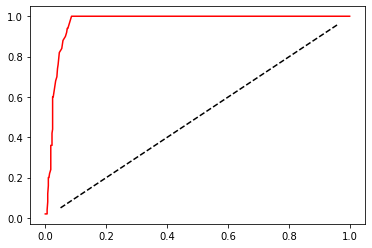

In [105]:
#开始绘图
recall = []
FPR = []

probrange = np.linspace(clf_proba.predict_proba(X)[:,1].min(),clf_proba.predict_proba(X)[:,1].max(),num=50,endpoint=False)

from sklearn.metrics import confusion_matrix as CM, recall_score as R
import matplotlib.pyplot as plot

for i in probrange:
    y_predict = []
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j,1] > i:
            y_predict.append(1)
        else:
            y_predict.append(0)
    cm = CM(y,y_predict,labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())
    
recall.sort()
FPR.sort()

plt.plot(FPR,recall,c="red")
plt.plot(probrange+0.05,probrange+0.05,c="black",linestyle="--")
plt.show()

![image.png](./images/237.png)

### 2.2.4 sklearn中的ROC曲线和AUC面积

![image.png](./images/238.png)

来看看我们如何使用：

In [120]:
from sklearn.metrics import roc_curve
FPR, recall, thresholds = roc_curve(y,clf_proba.decision_function(X), pos_label=1)

In [121]:
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [122]:
recall

array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [123]:
thresholds #此时的threshold就不是一个概率值，而是距离值中的阈值了，所以它可以大于1，也可以为负

array([  3.18236076,   2.18236076,   1.48676267,   1.35964325,
         1.33920817,   1.14038015,   1.13383091,   1.00003406,
         0.85085628,   0.84476439,   0.78571364,   0.60568093,
         0.5389064 ,   0.46718521,   0.44396046,   0.03907036,
        -0.07011269,  -0.10668727,  -0.1258212 ,  -0.13845693,
        -0.14034183,  -0.16790648,  -0.2040958 ,  -0.22137683,
        -0.24381463,  -0.26762451,  -0.34446784,  -0.3467975 ,
        -0.39182241,  -0.40676459,  -0.4589064 ,  -0.46310299,
        -0.49195707,  -0.5088941 ,  -0.53560561,  -0.55152081,
        -0.62628865,  -0.67580418,  -0.78127198,  -0.79874442,
        -0.88438995,  -0.91257798,  -1.01417607,  -1.08601917,
       -10.31959605])

sklearn.metrics.roc_auc_score (y_true, y_score, average=’macro’, sample_weight=None, max_fpr=None)
AUC面积的分数使用以上类来进行计算，输入的参数也比较简单，就是真实标签，和与roc_curve中一致的置信度
分数或者概率值。

In [114]:
from sklearn.metrics import roc_auc_score as AUC

area = AUC(y,clf_proba.decision_function(X))
area

0.9696400000000001

接下来就可以开始画图了：

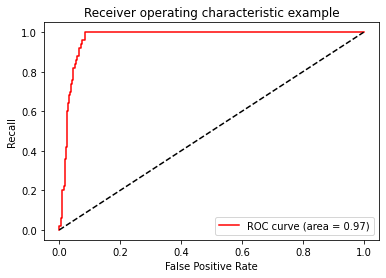

In [115]:
plt.figure()
plt.plot(FPR, recall, color='red',
         label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

如此就得到了我们的ROC曲线和AUC面积，可以看到，SVM在这个简单数据集上的效果还是非常好的。并且大家可
以通过观察我们使用decision_function画出的ROC曲线，对比一下我们之前强行使用概率画出来的曲线，两者非常
相似，所以在无法获取模型概率的情况下，其实不必强行使用概率，如果有置信度，那也使可以完成我们的ROC曲
线的。感兴趣的小伙伴可以画一下如果带上class_weight这个参数，模型的效果会变得如何。

#### 2.2.5 利用ROC曲线找出最佳阈值

现在，有了ROC曲线，了解了模型的分类效力，以及面对样本不均衡问题时的效力，那我们如何求解我们最佳的阈
值呢？我们想要了解，什么样的状况下我们的模型的效果才是最好的。回到我们对ROC曲线的理解来：ROC曲线反
应的是recall增加的时候FPR如何变化，也就是当模型捕获少数类的能力变强的时候，会误伤多数类的情况是否严
重。我们的希望是，模型在捕获少数类的能力变强的时候，尽量不误伤多数类，也就是说，随着recall的变大，FPR
的大小越小越好。所以我们希望找到的最有点，其实是Recall和FPR差距最大的点。这个点，又叫做**约登指数**。

In [125]:
max((recall - FPR).tolist())

0.914

In [ ]:
#list.index(最大值) #返回这个最大值在list中的索引

In [126]:
maxindex = (recall - FPR).tolist().index(max(recall - FPR))

In [127]:
thresholds[maxindex]

-1.0860191749391461

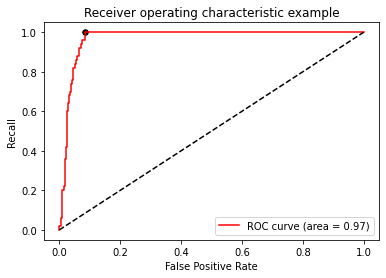

In [129]:
#我们可以在图像上来看看这个点在哪里
#plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30)
#把上述代码放入这段代码中：
plt.figure()
plt.plot(FPR, recall, color='red',
         label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

最佳阈值就这样选取出来了，由于现在我们是使用decision_function来画ROC曲线，所以我们选择出来的最佳阈值
其实是最佳距离。如果我们使用的是概率，我们选取的最佳阈值就会使一个概率值了。只要我们让这个距离/概率
以上的点，都为正类，让这个距离/概率以下的点都为负类，模型就是最好的：即能够捕捉出少数类，又能够尽量
不误伤多数类，整体的精确性和对少数类的捕捉都得到了保证。<br>
<br>
而从找出的最优阈值点来看，这个点，其实是图像上离左上角最近的点，离中间的虚线最远的点，也是ROC曲线的
转折点。如果没有时间进行计算，或者横坐标比较清晰的时候，我们就可以观察转折点来找到我们的最佳阈值。<br>
<br>
到这里为止，SVC的模型评估指标就介绍完毕了。但是，SVC的样本不均衡问题还可以有很多的探索。另外，我们
还可以使用KS曲线，或者收益曲线(profit chart)来选择我们的阈值，都是和ROC曲线类似的用法。大家若有余力，
可以自己深入研究一下。模型评估指标，还有很多深奥的地方

## 4 SVC真实数据案例：预测明天是否会下雨

![image.png](./images/239.png)

### 4.1 导库导数据，探索特征

**导入需要的库**

In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

**导入数据，探索数据**

In [133]:
weather = pd.read_csv(r".\datasets\weatherAUS5000.csv",index_col=0)
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7,No
1,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3,No
2,2010-02-08,Adelaide,24.0,38.1,0.0,23.4,13.0,SE,39.0,NNE,...,19.0,36.0,24.0,1018.0,1016.0,NaN,NaN,32.4,37.4,No
3,2016-09-19,Adelaide,6.7,16.4,0.4,NaN,NaN,N,31.0,N,...,15.0,65.0,40.0,1014.4,1010.0,NaN,NaN,11.2,15.9,No
4,2014-03-05,Adelaide,16.7,24.8,0.0,6.6,11.7,S,37.0,S,...,24.0,61.0,48.0,1019.3,1018.9,NaN,NaN,20.8,23.7,No


来查看一下各个特征都代表了什么：

![image.png](./images/240.png)

![image.png](./images/241.png)

In [134]:
#将特征矩阵和标签Y分开
X = weather.iloc[:,:-1]
Y = weather.iloc[:,-1]

In [135]:
X.shape
#探索数据类型

(5000, 21)

In [136]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           5000 non-null   object 
 1   Location       5000 non-null   object 
 2   MinTemp        4979 non-null   float64
 3   MaxTemp        4987 non-null   float64
 4   Rainfall       4950 non-null   float64
 5   Evaporation    2841 non-null   float64
 6   Sunshine       2571 non-null   float64
 7   WindGustDir    4669 non-null   object 
 8   WindGustSpeed  4669 non-null   float64
 9   WindDir9am     4651 non-null   object 
 10  WindDir3pm     4887 non-null   object 
 11  WindSpeed9am   4949 non-null   float64
 12  WindSpeed3pm   4919 non-null   float64
 13  Humidity9am    4936 non-null   float64
 14  Humidity3pm    4880 non-null   float64
 15  Pressure9am    4506 non-null   float64
 16  Pressure3pm    4504 non-null   float64
 17  Cloud9am       3111 non-null   float64
 18  Cloud3pm

In [137]:
#探索缺失值
X.isnull().mean()  # 缺失值所占总值的比例 isnull().sum()（全部的true）/X.shape[0]
# 我们要有不同的缺失值填补策略

# 在上方添加一个新的cell ESC a enter
# 在下方添加一个新的cell ESC b enter

#分割一个cell  shift+ctrl+-
#合并多个cell  选中多个cell shift+m

Date             0.0000
Location         0.0000
MinTemp          0.0042
MaxTemp          0.0026
Rainfall         0.0100
Evaporation      0.4318
Sunshine         0.4858
WindGustDir      0.0662
WindGustSpeed    0.0662
WindDir9am       0.0698
WindDir3pm       0.0226
WindSpeed9am     0.0102
WindSpeed3pm     0.0162
Humidity9am      0.0128
Humidity3pm      0.0240
Pressure9am      0.0988
Pressure3pm      0.0992
Cloud9am         0.3778
Cloud3pm         0.3976
Temp9am          0.0066
Temp3pm          0.0176
dtype: float64

In [139]:
Y.shape

(5000,)

In [140]:
Y.isnull().sum()

0

In [138]:
#探索标签的分类
np.unique(Y) #我们的标签是二分类

array(['No', 'Yes'], dtype=object)

粗略观察可以发现，这个特征矩阵由一部分分类变量和一部分连续变量组成，其中云层遮蔽程度虽然是以数字表
示，但是本质却是分类变量。大多数特征都是采集的自然数据，比如蒸发量，日照时间，湿度等等，而少部分特征
是人为构成的。还有一些是单纯表示样本信息的变量，比如采集信息的地点，以及采集的时间。

### 4.2 分集，优先探索标签

In [141]:
#分训练集和测试集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.3,random_state=420)

In [142]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
1809,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
4176,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,7.0,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6
110,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,17.0,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8
3582,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,11.0,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5
2162,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4


In [143]:
#恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

In [144]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,7.0,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,17.0,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,11.0,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4


In [147]:
Ytrain.head()

0     No
1     No
2     No
3    Yes
4     No
Name: RainTomorrow, dtype: object

在现实中，我们会先分训练集和测试集，再开始进行数据预处理。这是由于，测试集在现实中往往是不可获得的，
或者被假设为是不可获得的，我们不希望我们建模的任何过程受到测试集数据的影响，否则的话，就相当于提前告
诉了模型一部分预测的答案。在之前的课中，为了简便操作，都给大家忽略了这个过程，一律先进行预处理，再分
训练集和测试集，这是一种不规范的做法。在这里，为了让案例尽量接近真实的样貌，所以采取了现实中所使用的
这种方式：先分训练集和测试集，再一步步进行预处理。这样导致的结果是，我们对训练集执行的所有操作，都必
须对测试集执行一次，工作量是翻倍的。

In [145]:
#是否有样本不平衡问题？
Ytrain.value_counts()

No     2704
Yes     796
Name: RainTomorrow, dtype: int64

In [146]:
Ytest.value_counts()

No     1157
Yes     343
Name: RainTomorrow, dtype: int64

In [149]:
#有轻微的样本不均衡问题
Ytrain.value_counts()[0]/Ytrain.value_counts()[1]

3.3969849246231156

In [150]:
#将标签编码
from sklearn.preprocessing import LabelEncoder  # 标签专用
encorder = LabelEncoder().fit(Ytrain) # 允许一维数据的输入的
#认得了：有两类，YES和NO，YES是1，NO是0

In [151]:
#使用训练集进行训练，然后在训练集和测试集上分别进行transform
Ytrain = pd.DataFrame(encorder.transform(Ytrain))
Ytest = pd.DataFrame(encorder.transform(Ytest))

#如果我们的测试集中，出现了训练集中没有出现过的标签类别
#比如说，测试集中有YES，NO,UNKNOWN，而我们的训练集中只有YES和NO，transform就会报错

In [153]:
Ytrain.head()

,0
0,0
1,0
2,0
3,1
4,0


In [154]:
Ytest.head()

,0
0,0
1,0
2,1
3,0
4,0


In [155]:
Ytrain.to_csv("F:\machineLearningcsv\predictRainYtrain.csv")

### 4.3 探索特征，开始处理特征矩阵

#### 4.3.1 描述性统计与异常值

In [156]:
#描述性统计
Xtrain.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
MinTemp,3486.0,12.225645,6.396243,-6.5,-1.715,1.800,4.1,7.7,12.0,16.7,20.9,25.900,29.0
MaxTemp,3489.0,23.245543,7.201839,-3.7,8.888,12.840,14.5,18.0,22.5,28.4,33.0,40.400,46.4
Rainfall,3467.0,2.487049,7.949686,0.0,0.000,0.000,0.0,0.0,0.0,0.8,6.6,41.272,115.8
Evaporation,1983.0,5.619163,4.383098,0.0,0.400,0.800,1.4,2.6,4.8,7.4,10.2,20.600,56.0
Sunshine,1790.0,7.508659,3.805841,0.0,0.000,0.345,1.4,4.6,8.3,10.6,12.0,13.300,13.9
WindGustSpeed,3263.0,39.858413,13.219607,9.0,15.000,20.000,24.0,31.0,39.0,48.0,57.0,76.000,117.0
WindSpeed9am,3466.0,14.046163,8.670472,0.0,0.000,0.000,4.0,7.0,13.0,19.0,26.0,37.000,65.0
WindSpeed3pm,3437.0,18.553390,8.611818,0.0,2.000,6.000,7.0,13.0,19.0,24.0,30.0,43.000,65.0
Humidity9am,3459.0,69.069095,18.787698,2.0,18.000,35.000,45.0,57.0,70.0,83.0,94.0,100.000,100.0
Humidity3pm,3408.0,51.651995,20.697872,2.0,9.000,17.000,23.0,37.0,52.0,66.0,79.0,98.000,100.0


In [157]:
Xtest.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
MinTemp,1493.0,11.916812,6.375377,-8.5,-2.024,1.600,3.70,7.3,11.8,16.5,20.48,25.316,28.3
MaxTemp,1498.0,22.906809,6.986043,-0.8,9.134,13.000,14.50,17.8,22.4,27.8,32.60,38.303,45.1
Rainfall,1483.0,2.241807,7.988822,0.0,0.000,0.000,0.00,0.0,0.0,0.8,5.20,35.372,108.2
Evaporation,858.0,5.657809,4.105762,0.0,0.400,1.000,1.60,2.8,4.8,7.6,10.40,19.458,38.8
Sunshine,781.0,7.677465,3.862294,0.0,0.000,0.300,1.50,4.7,8.6,10.7,12.20,13.400,13.9
WindGustSpeed,1406.0,40.044097,14.027052,9.0,15.000,20.000,24.00,30.0,39.0,48.0,57.00,78.000,122.0
WindSpeed9am,1483.0,13.986514,9.124337,0.0,0.000,0.000,4.00,7.0,13.0,20.0,26.00,39.360,72.0
WindSpeed3pm,1482.0,18.601215,8.850446,0.0,2.000,6.000,7.00,13.0,19.0,24.0,31.00,43.000,56.0
Humidity9am,1477.0,68.688558,18.876448,4.0,20.000,36.000,44.00,57.0,69.0,82.0,95.00,100.000,100.0
Humidity3pm,1472.0,51.431386,20.459957,2.0,8.710,18.000,23.00,37.0,52.0,66.0,78.00,96.290,100.0


In [ ]:
"""
对于去kaggle上下载了数据的小伙伴们，以及坚持要使用完整版数据的（15W行）小伙伴们
如果你发现了异常值，首先你要观察，这个异常值出现的频率
如果异常值只出现了一次，多半是输入错误，直接把异常值删除
如果异常值出现了多次，去跟业务人员沟通，可能这是某种特殊表示，如果是人为造成的错误，异常值留着是没有用
的，只要数据量不是太大，都可以删除
如果异常值占到你总数据量的10%以上了，不能轻易删除。可以考虑把异常值替换成非异常但是非干扰的项，比如说用0
来进行替换，或者把异常当缺失值，用均值或者众数来进行替换
"""
#先查看原始的数据结构
Xtrain.shape
Xtest.shape
#观察异常值是大量存在，还是少数存在
Xtrain.loc[Xtrain.loc[:,"Cloud9am"] == 9,"Cloud9am"]
Xtest.loc[Xtest.loc[:,"Cloud9am"] == 9,"Cloud9am"]
Xtest.loc[Xtest.loc[:,"Cloud3pm"] == 9,"Cloud3pm"]
#少数存在，于是采取删除的策略
#注意如果删除特征矩阵，则必须连对应的标签一起删除，特征矩阵的行和标签的行必须要一一对应
Xtrain = Xtrain.drop(index = 71737)
Ytrain = Ytrain.drop(index = 71737)
#删除完毕之后，观察原始的数据结构，确认删除正确
Xtrain.shape
Xtest = Xtest.drop(index = [19646,29632])
Ytest = Ytest.drop(index = [19646,29632])
Xtest.shape
#进行任何行删除之后，千万记得要恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])
Xtrain.head()
Xtest.head()

#### 4.3.2 处理困难特征：日期

我们采集数据的日期是否和我们的天气有关系呢？我们可以探索一下我们的采集日期有什么样的性质：

In [158]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,7.0,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,17.0,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,11.0,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4


In [159]:
type(Xtrain.iloc[0,0]) # 字符串

str

In [ ]:
#我们现在拥有的日期特征，是连续型特征，还是分类型特征
#2019-1-6
#2019-1-6.5
#日期是一年分了365类的分类型变量
#我们的日期特征中，日期是否有重复

In [162]:
Xtrain.iloc[:,0].value_counts()

2014-05-16    6
2015-07-03    6
2015-10-12    6
2016-11-01    5
2011-09-04    5
             ..
2008-08-14    1
2009-12-12    1
2009-02-02    1
2011-08-12    1
2009-05-16    1
Name: Date, Length: 2141, dtype: int64

In [163]:
Xtrainc = Xtrain.copy()

Xtrainc.sort_values(by="Location")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
2796,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,13.0,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7
2975,2012-08-17,Adelaide,7.8,13.2,17.6,0.8,NaN,SW,61.0,SW,...,20.0,28.0,76.0,47.0,1012.5,1014.7,NaN,NaN,8.3,12.5
775,2013-03-16,Adelaide,17.4,23.8,NaN,NaN,9.7,SSE,46.0,S,...,9.0,19.0,63.0,57.0,1019.9,1020.5,NaN,NaN,19.1,20.7
861,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3
2906,2015-08-24,Adelaide,9.2,14.3,0.0,NaN,NaN,SE,48.0,SE,...,17.0,19.0,64.0,42.0,1024.7,1024.1,NaN,NaN,9.9,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,2009-05-08,Woomera,9.2,20.6,0.0,5.2,10.4,ESE,37.0,SE,...,19.0,19.0,64.0,34.0,1030.5,1026.9,0.0,1.0,13.7,20.1
1984,2014-05-26,Woomera,15.5,23.6,0.0,24.0,NaN,NNW,43.0,NNE,...,9.0,26.0,49.0,37.0,1014.2,1010.3,7.0,7.0,18.0,21.5
1592,2012-01-10,Woomera,16.8,26.7,0.0,10.0,5.3,SW,46.0,S,...,20.0,22.0,52.0,33.0,1019.1,1016.8,4.0,6.0,18.3,24.9
2824,2015-11-03,Woomera,16.2,28.5,7.8,4.2,4.5,WSW,80.0,NE,...,26.0,50.0,76.0,53.0,1009.6,1006.8,6.0,7.0,20.5,26.2


In [166]:
Xtrainc.loc[Xtrainc.iloc[:,0] == "2015-08-24",:]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
2906,2015-08-24,Adelaide,9.2,14.3,0.0,NaN,NaN,SE,48.0,SE,...,17.0,19.0,64.0,42.0,1024.7,1024.1,NaN,NaN,9.9,13.4


In [164]:
Xtrain.iloc[:,0].value_counts()
#首先，日期不是独一无二的，日期有重复
#其次，在我们分训练集和测试集之后，日期也不是连续的，而是分散的
#某一年的某一天倾向于会下雨？或者倾向于不会下雨吗？
#不是日期影响了下雨与否，反而更多的是这一天的日照时间，湿度，温度等等这些因素影响了是否会下雨
#光看日期，其实感觉它对我们的判断并无直接影响
#如果我们把它当作连续型变量处理，那算法会人为它是一系列1~3000左右的数字，不会意识到这是日期

2014-05-16    6
2015-07-03    6
2015-10-12    6
2016-11-01    5
2011-09-04    5
             ..
2008-08-14    1
2009-12-12    1
2009-02-02    1
2011-08-12    1
2009-05-16    1
Name: Date, Length: 2141, dtype: int64

In [165]:
Xtrain.iloc[:,0].value_counts().count()
#如果我们把它当作分类型变量处理，类别太多，有2141类，如果换成数值型，会被直接当成连续型变量，如果做成哑变量，我们特征的维度会爆炸

2141

如果我们的思考简单一些，我们可以直接删除日期这个特征。首先它不是一个直接影响我们标签的特征，并且要处
理日期其实是非常困难的。如果大家认可这种思路，那可以直接运行下面的代码来删除我们的日期：

In [ ]:
Xtrain = Xtrain.drop(["Date"],axis=1)
Xtest = Xtest.drop(["Date"],axis=1)

In [ ]:
#进行任何行删除之后，千万记得要恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

![image.png](./images/242.png)

In [167]:
Xtrain["Rainfall"].head(20)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.2
8      0.0
9      0.2
10     1.0
11     0.0
12     0.2
13     0.0
14     0.0
15     3.0
16     0.2
17     0.0
18    35.2
19     0.0
Name: Rainfall, dtype: float64

In [168]:
Xtrain["Rainfall"].isnull().sum()
#假设你没有下雨
#复制你的空值

33

In [170]:
Xtrain.loc[Xtrain.loc[:,"Rainfall"] >= 1,"RainToday"] = "Yes"
Xtrain.loc[Xtrain["Rainfall"] < 1,"RainToday"] = "No"
Xtrain.loc[Xtrain["Rainfall"] == np.nan,"RainToday"] = np.nan

e:\python\python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
e:\python\python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [174]:
Xtest.loc[Xtest["Rainfall"] >= 1,"RainToday"] = "Yes"
Xtest.loc[Xtest["Rainfall"] < 1,"RainToday"] = "No"
Xtest.loc[Xtest["Rainfall"] == np.nan,"RainToday"] = np.nan

e:\python\python37\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
e:\python\python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
e:\python\python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [171]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [173]:
Xtrain.loc[:,"RainToday"].value_counts()

No     2642
Yes     825
Name: RainToday, dtype: int64

In [175]:
Xtest.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2016-01-23,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,2009-03-05,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,2010-03-05,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-26,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,2016-11-28,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


如此，我们就创造了一个特征，今天是否下雨“RainToday”。<br>
<br>
那现在，我们是否就可以将日期删除了呢？对于我们而言，日期本身并不影响天气，但是日期所在的月份和季节其
实是影响天气的，如果任选梅雨季节的某一天，那明天下雨的可能性必然比非梅雨季节的那一天要大。虽然我们无
法让机器学习体会不同月份是什么季节，但是我们可以对不同月份进行分组，算法可以通过训练感受到，“这个月
或者这个季节更容易下雨”。因此，我们可以将月份或者季节提取出来，作为一个特征使用，而舍弃掉具体的日
期。如此，我们又可以创造第二个特征，月份"Month"。

In [176]:
Xtrain.loc[0,"Date"].split("-")

['2015', '08', '24']

In [177]:
int(Xtrain.loc[0,"Date"].split("-")[1]) #提取出月份

8

In [178]:
Xtrain["Date"] = Xtrain["Date"].apply(lambda x:int(x.split("-")[1]))
#apply是对dataframe上的某一列进行处理的一个函数
#lambda x匿名函数，请在dataframe上这一列中的每一行帮我执行冒号后面的命令

e:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [179]:
Xtrain["Date"].head()

0     8
1    12
2     4
3    11
4     4
Name: Date, dtype: int64

In [180]:
Xtrain["Date"].value_counts()

3     334
5     324
7     316
6     302
9     302
1     300
11    299
10    282
4     265
2     264
12    259
8     253
Name: Date, dtype: int64

In [181]:
#替换完毕后，我们需要修改列的名称
#rename是比较少有的，可以用来修改单个列名的函数
#我们通常都直接使用 df.columns = 某个列表 这样的形式来一次修改所有的列名
#但rename允许我们只修改某个单独的列
Xtrain = Xtrain.rename(columns={"Date":"Month"})

In [182]:
Xtrain.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [183]:
Xtest["Date"] = Xtest["Date"].apply(lambda x:int(x.split("-")[1]))
Xtest = Xtest.rename(columns={"Date":"Month"})
Xtest.head()

e:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


通过时间，我们处理出两个新特征，“今天是否下雨”和“月份”。接下来，让我们来看看如何处理另一个更加困难的
特征，地点。

#### 4.3.3 处理困难特征：地点

地点，又是一个非常tricky的特征。常识上来说，我们认为地点肯定是对明天是否会下雨存在影响的。比如说，如果其他信息都不给出，我们只猜测，“伦敦明天是否会下雨”和”北京明天是否会下雨“，我一定会猜测伦敦会下雨，而北京不会，因为伦敦是常年下雨的城市，而北京的气候非常干燥。对澳大利亚这样面积巨大的国家来说，必然存在着不同的城市有着不同的下雨倾向的情况。但尴尬的是，和时间一样，我们输入地点的名字对于算法来说，就是一串字符，"London"和"Beijing"对算法来说，和0，1没有区别。同样，我们的样本中含有49个不同地点，如果做成分类型变量，算法就无法辨别它究竟是否是分类变量。也就是说，我们需要让算法意识到，不同的地点因为气候不同，所以对“明天是否会下雨”有着不同的影响。如果我们能够将地点转换为这个地方的气候的话，我们就可以将不同城市打包到同一个气候中，而同一个气候下反应的降雨情况应该是相似的。<br>
<br>
那我们如何将城市转换为气候呢？我在google找到了如下地图：

In [185]:
Xtrain["Location"].value_counts().count()
#超过25个类别的分类型变量，都会被算法当成是连续型变量

49

![image.png](./images/243.png)

爬虫的代码如下所示，大家可以把谷歌的主页换成百度，修改一下爬虫的命令，就可以自己试试看这段代码。**注意
要先定义你需要爬取的城市名称的列表cityname哦。**

In [ ]:
import time
from selenium import webdriver #导入需要的模块，其中爬虫使用的是selenium
import pandas as pd
import numpy as np
df = pd.DataFrame(index=range(len(cityname))) #创建新dataframe用于存储爬取的数据
driver = webdriver.Chrome() #调用谷歌浏览器
time0 = time.time() #计时开始
#循环开始
for num, city in enumerate(cityname): #在城市名称中进行遍历
driver.get('https://www.google.co.uk/webhp?
hl=en&sa=X&ved=0ahUKEwimtcX24cTfAhUJE7wKHVkWB5AQPAgH')
        #首先打开谷歌主页
    time.sleep(0.3)
        #停留0.3秒让我们知道发生了什么
    search_box = driver.find_element_by_name('q') #锁定谷歌的搜索输入框
    search_box.send_keys('%s Australia Latitude and longitude' % (city)) #在输入框中输入“城市” 澳大利亚 经纬度    
    search_box.submit() #enter，确认开始搜索
    result = driver.find_element_by_xpath('//div[@class="Z0LcW"]').text #？爬取需要的经纬度，就是这里，怎么获取的呢？
    resultsplit = result.split(" ") #将爬取的结果用split进行分割
    df.loc[num,"City"] = city #向提前创建好的df中输入爬取的数据，第一列是城市名
    df.loc[num,"Latitude"] = resultsplit[0] #第二列是纬度
    df.loc[num,"Longitude"] = resultsplit[2] #第三列是经度
    df.loc[num,"Latitudedir"] = resultsplit[1] #第四列是纬度的方向
    df.loc[num,"Longitudedir"] = resultsplit[3] #第五列是经度的方向
    print("%i webcrawler successful for city %s" % (num,city)) #每次爬虫成功之后，就打印“城市”成功了
    
time.sleep(1) #全部爬取完毕后，停留1秒钟
driver.quit() #关闭浏览器
print(time.time() - time0) #打印所需的时间

为什么我们会需要城市的经纬度呢？我曾经尝试过直接使用样本中的城市来爬取城市本身的气候，然而由于样本中
的地点名称，其实是气候站的名称，而不是城市本身的名称，因此不是每一个城市都能够直接获取到城市的气候。<br>
<br>
比如说，如果我们搜索“海淀区气候”，搜索引擎返回的可能是海淀区现在的气温，而不是整个北京的气候类型。因
此，我们需要澳大利亚气象局的数据，来找到这些气候站所对应的城市。<br>
<br>
我们有了澳大利亚全国主要城市的气候，也有了澳大利亚主要城市的经纬度（地点），我们就可以通过计算我们样
本中的每个气候站到各个主要城市的地理距离，来找出一个离这个气象站最近的主要城市，而这个主要城市的气候
就是我们样本点所在的地点的气候。<br>
<br>
让我们把cityll.csv和cityclimate.csv来导入，来看看它们是什么样子：

In [186]:
cityll=pd.read_csv(r"./datasets/cityll.csv",index_col=0)
city_climate=pd.read_csv(r"./datasets/Cityclimate.csv")

In [187]:
cityll.head() #每个城市对应的经纬度，这些城市是澳大利亚统计局做的那张地图上的城市

,City,Latitude,Longitude,Latitudedir,Longitudedir
0,Adelaide,34.9285°,138.6007°,"S,",E
1,Albany,35.0275°,117.8840°,"S,",E
2,Albury,36.0737°,146.9135°,"S,",E
3,Wodonga,36.1241°,146.8818°,"S,",E
4,AliceSprings,23.6980°,133.8807°,"S,",E


In [191]:
float(cityll.loc[0,"Latitude"][:-1])

34.9285

In [192]:
#去掉度数符号
cityll["Latitudenum"] = cityll["Latitude"].apply(lambda x:float(x[:-1]))
cityll["Longitudenum"] = cityll["Longitude"].apply(lambda x:float(x[:-1]))

In [193]:
cityll.head()

,City,Latitude,Longitude,Latitudedir,Longitudedir,Latitudenum,Longitudenum
0,Adelaide,34.9285°,138.6007°,"S,",E,34.9285,138.6007
1,Albany,35.0275°,117.8840°,"S,",E,35.0275,117.8840
2,Albury,36.0737°,146.9135°,"S,",E,36.0737,146.9135
3,Wodonga,36.1241°,146.8818°,"S,",E,36.1241,146.8818
4,AliceSprings,23.6980°,133.8807°,"S,",E,23.6980,133.8807


In [195]:
cityll.loc[:,"Latitudedir"].value_counts()

S,    100
Name: Latitudedir, dtype: int64

In [196]:
#观察一下所有的经纬度方向都是一致的，全部是南纬，东经，因为澳大利亚在南半球，东半球
#所以经纬度的方向我们可以舍弃了
citylld = cityll.iloc[:,[0,5,6]]

In [188]:
city_climate.head() #澳大利亚统计局做的每个城市对应的气候

,City,Climate
0,Adelaide,Warm temperate
1,Albany,Mild temperate
2,Albury,"Hot dry summer, cool winter"
3,Wodonga,"Hot dry summer, cool winter"
4,AliceSprings,"Hot dry summer, warm winter"


接下来，我们来将这两张表处理成可以使用的样子，首先要去掉cityll中经纬度上带有的度数符号，然后要将两张表
合并起来。

In [197]:
#将city_climate中的气候添加到我们的citylld中
citylld["climate"] = city_climate.iloc[:,-1]
citylld.head()

e:\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,City,Latitudenum,Longitudenum,climate
0,Adelaide,34.9285,138.6007,Warm temperate
1,Albany,35.0275,117.8840,Mild temperate
2,Albury,36.0737,146.9135,"Hot dry summer, cool winter"
3,Wodonga,36.1241,146.8818,"Hot dry summer, cool winter"
4,AliceSprings,23.6980,133.8807,"Hot dry summer, warm winter"


In [199]:
city_climate.loc[:,"Climate"].value_counts()

Hot dry summer, cool winter          24
Warm temperate                       18
Hot dry summer, warm winter          18
High humidity summer, warm winter    17
Mild temperate                        9
Cool temperate                        9
Warm humid summer, mild winter        5
Name: Climate, dtype: int64

看菜菜的pdf

In [200]:
samplecity = pd.read_csv(r"./datasets/samplecity.csv",index_col=0)

In [201]:
samplecity.head()

,City,Latitude,Longitude,Latitudedir,Longitudedir
0,Canberra,35.2809°,149.1300°,"S,",E
1,Sydney,33.8688°,151.2093°,"S,",E
2,Perth,31.9505°,115.8605°,"S,",E
3,Darwin,12.4634°,130.8456°,"S,",E
4,Hobart,42.8821°,147.3272°,"S,",E


In [202]:
#我们对samplecity也执行同样的处理：去掉经纬度中度数的符号，并且舍弃我们的经纬度的方向
samplecity["Latitudenum"] = samplecity["Latitude"].apply(lambda x:float(x[:-1]))
samplecity["Longitudenum"] = samplecity["Longitude"].apply(lambda x:float(x[:-1]))
samplecityd = samplecity.iloc[:,[0,5,6]]
samplecityd.head()

,City,Latitudenum,Longitudenum
0,Canberra,35.2809,149.1300
1,Sydney,33.8688,151.2093
2,Perth,31.9505,115.8605
3,Darwin,12.4634,130.8456
4,Hobart,42.8821,147.3272


![image.png](./images/244.png)

In [203]:
#首先使用radians将角度转换成弧度
from math import radians, sin, cos, acos
citylld.loc[:,"slat"] = citylld.iloc[:,1].apply(lambda x : radians(x))
citylld.loc[:,"slon"] = citylld.iloc[:,2].apply(lambda x : radians(x))
samplecityd.loc[:,"elat"] = samplecityd.iloc[:,1].apply(lambda x : radians(x))
samplecityd.loc[:,"elon"] = samplecityd.iloc[:,2].apply(lambda x : radians(x))

e:\python\python37\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
e:\python\python37\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [204]:
import sys
for i in range(samplecityd.shape[0]):
    slat = citylld.loc[:,"slat"]
    slon = citylld.loc[:,"slon"]
    elat = samplecityd.loc[i,"elat"]
    elon = samplecityd.loc[i,"elon"]
    dist = 6371.01 * np.arccos(np.sin(slat)*np.sin(elat) +
                          np.cos(slat)*np.cos(elat)*np.cos(slon.values - elon))
    city_index = np.argsort(dist)[0]
    #每次计算后，取距离最近的城市，然后将最近的城市和城市对应的气候都匹配到samplecityd中
    samplecityd.loc[i,"closest_city"] = citylld.loc[city_index,"City"]
    samplecityd.loc[i,"climate"] = citylld.loc[city_index,"climate"]

e:\python\python37\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
e:\python\python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
e:\python\python37\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [206]:
#查看最后的结果，需要检查城市匹配是否基本正确
samplecityd.head(20)

,City,Latitudenum,Longitudenum,elat,elon,closest_city,climate
0,Canberra,35.2809,149.1300,0.615768,2.602810,Canberra,Cool temperate
1,Sydney,33.8688,151.2093,0.591122,2.639100,Sydney,Warm temperate
2,Perth,31.9505,115.8605,0.557641,2.022147,Perth,Warm temperate
3,Darwin,12.4634,130.8456,0.217527,2.283687,Darwin,"High humidity summer, warm winter"
4,Hobart,42.8821,147.3272,0.748434,2.571345,Hobart,Cool temperate
5,Brisbane,27.4698,153.0251,0.479438,2.670792,Brisbane,"Warm humid summer, mild winter"
6,Adelaide,34.9285,138.6007,0.609617,2.419039,Adelaide,Warm temperate
7,Bendigo,36.7570,144.2794,0.641531,2.518151,Ballarat,Cool temperate
8,Townsville,19.2590,146.8169,0.336133,2.562438,Townsville,"High humidity summer, warm winter"
9,AliceSprings,23.6980,133.8807,0.413608,2.336659,AliceSprings,"Hot dry summer, warm winter"


In [207]:
#查看气候的分布
samplecityd["climate"].value_counts()

Warm temperate                       15
Mild temperate                       10
Cool temperate                        9
Hot dry summer, cool winter           6
High humidity summer, warm winter     4
Hot dry summer, warm winter           3
Warm humid summer, mild winter        2
Name: climate, dtype: int64

In [208]:
#确认无误后，取出样本城市所对应的气候，并保存
locafinal = samplecityd.iloc[:,[0,-1]]

In [211]:
locafinal.head()

,Location,Climate
0,Canberra,Cool temperate
1,Sydney,Warm temperate
2,Perth,Warm temperate
3,Darwin,"High humidity summer, warm winter"
4,Hobart,Cool temperate


In [210]:
locafinal.columns = ["Location","Climate"]

In [212]:
#在这里设定locafinal的索引为地点，是为了之后进行map的匹配
locafinal = locafinal.set_index(keys="Location")
locafinal.to_csv(r"F:\machineLearningcsv\samplelocation.csv")
locafinal.head()

,Climate
Location,
Canberra,Cool temperate
Sydney,Warm temperate
Perth,Warm temperate
Darwin,"High humidity summer, warm winter"
Hobart,Cool temperate


有了每个样本城市所对应的气候，我们接下来就使用气候来替掉原本的城市，原本的气象站的名称。在这里，我们
可以使用map功能，map能够将特征中的值一一对应到我们设定的字典中，并且用字典中的值来替换样本中原本的
值，我们在评分卡中曾经使用这个功能来用WOE替换我们原本的特征的值。

In [218]:
#是否还记得训练集长什么样呢？
Xtrain.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,High humidity summer warm winter,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Cool temperate,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Mild temperate,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Mild temperate,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Hot dry summer cool winter,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [214]:
#城市替换成城市对应的气候
Xtrain["Location"]=Xtrain["Location"].map(locafinal.iloc[:,0])

In [217]:
import re
#城市的气候中所含的逗号和空格都去掉
Xtrain["Location"]=Xtrain["Location"].apply(lambda x:re.sub(",","",x.strip()))

In [225]:
#将location中的内容替换，并且确保匹配进入的气候字符串中不含有逗号，气候两边不含有空格
#我们使用re这个模块来消除逗号
#re.sub(希望替换的值，希望被替换成的值，要操作的字符串)
#x.strip()是去掉空格的函数
#吧location替换成气候的是我们的map的映射
import re
#Xtrain["Location"] = Xtrain["Location"].map(locafinal.iloc[:,0]).apply(lambda x:re.sub(",","",x.strip()))
Xtest["Location"] = Xtest["Location"].map(locafinal.iloc[:,0]).apply(lambda x:re.sub(",","",x.strip()))

In [221]:
#修改特征内容之后，我们使用新列名“Climate”来替换之前的列名“Location”
#注意这个命令一旦执行之后，就再没有列"Location"了，使用索引时要特别注意
Xtrain = Xtrain.rename(columns={"Location":"Climate"})
Xtest = Xtest.rename(columns={"Location":"Climate"})

In [222]:
Xtrain.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,High humidity summer warm winter,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Cool temperate,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Mild temperate,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Mild temperate,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Hot dry summer cool winter,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [226]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,Cool temperate,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,Mild temperate,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,Cool temperate,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Warm temperate,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Mild temperate,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


到这里，地点就处理完毕了。其实，我们还没有将这个特征转化为数字，即还没有对它进行编码。我们稍后和其他
的分类型变量一起来编码。

#### 4.3.4 处理分类型变量：缺失值

接下来，我们总算可以开始处理我们的缺失值了。首先我们要注意到，由于我们的特征矩阵由两种类型的数据组
成：分类型和连续型，因此我们必须对两种数据采用不同的填补缺失值策略。传统地，如果是分类型特征，我们则
采用众数进行填补。如果是连续型特征，我们则采用均值来填补。<br>
<br>
此时，由于我们已经分了训练集和测试集，我们需要考虑一件事：究竟使用哪一部分的数据进行众数填补呢？答案
是，使用训练集上的众数对训练集和测试集都进行填补。为什么会这样呢？按道理说就算用测试集上的众数对测试
集进行填补，也不会使测试集数据进入我们建好的模型，不会给模型透露一些信息。然而，在现实中，我们的测试
集未必是很多条数据，也许我们的测试集只有一条数据，而某个特征上是空值，此时此刻测试集本身的众数根本不
存在，要如何利用测试集本身的众数去进行填补呢？因此为了避免这种尴尬的情况发生，我们假设测试集和训练集
的数据分布和性质都是相似的，因此我们统一使用训练集的众数和均值来对测试集进行填补。<br>
<br>
在sklearn当中，即便是我们的填补缺失值的类也需要由实例化，fit和接口调用执行填补三个步骤来进行，而这种
分割其实一部分也是为了满足我们使用训练集的建模结果来填补测试集的需求。我们只需要实例化后，使用训练集
进行fit，然后在调用接口执行填补时用训练集fit后的结果分别来填补测试集和训练集就可以了。

In [227]:
#查看缺失值的缺失情况
Xtrain.isnull().mean()

Month            0.000000
Climate          0.000000
MinTemp          0.004000
MaxTemp          0.003143
Rainfall         0.009429
Evaporation      0.433429
Sunshine         0.488571
WindGustDir      0.067714
WindGustSpeed    0.067714
WindDir9am       0.067429
WindDir3pm       0.024286
WindSpeed9am     0.009714
WindSpeed3pm     0.018000
Humidity9am      0.011714
Humidity3pm      0.026286
Pressure9am      0.098857
Pressure3pm      0.098857
Cloud9am         0.379714
Cloud3pm         0.401429
Temp9am          0.005429
Temp3pm          0.019714
RainToday        0.009429
dtype: float64

In [228]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Month          3500 non-null   int64  
 1   Climate        3500 non-null   object 
 2   MinTemp        3486 non-null   float64
 3   MaxTemp        3489 non-null   float64
 4   Rainfall       3467 non-null   float64
 5   Evaporation    1983 non-null   float64
 6   Sunshine       1790 non-null   float64
 7   WindGustDir    3263 non-null   object 
 8   WindGustSpeed  3263 non-null   float64
 9   WindDir9am     3264 non-null   object 
 10  WindDir3pm     3415 non-null   object 
 11  WindSpeed9am   3466 non-null   float64
 12  WindSpeed3pm   3437 non-null   float64
 13  Humidity9am    3459 non-null   float64
 14  Humidity3pm    3408 non-null   float64
 15  Pressure9am    3154 non-null   float64
 16  Pressure3pm    3154 non-null   float64
 17  Cloud9am       2171 non-null   float64
 18  Cloud3pm

In [230]:
#首先找出，分类型特征都有哪些
cate = Xtrain.columns[Xtrain.dtypes == "object"].tolist()
cate

['Climate', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [231]:
#除了特征类型为"object"的特征们，还有虽然用数字表示，但是本质为分类型特征的云层遮蔽程度
cloud = ["Cloud9am","Cloud3pm"]
cate = cate + cloud
cate

['Climate',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'Cloud9am',
 'Cloud3pm']

In [233]:
#对于分类型特征，我们使用众数来进行填补
from sklearn.impute import SimpleImputer #0.20

si = SimpleImputer(missing_values=np.nan,strategy="most_frequent")

#注意，我们使用训练集数据来训练我们的填补器，本质是在生成训练集中的众数
si.fit(Xtrain.loc[:,cate])

SimpleImputer(strategy='most_frequent')

In [234]:
#然后我们用训练集中的众数来同时填补训练集和测试集
Xtrain.loc[:,cate] = si.transform(Xtrain.loc[:,cate])
Xtest.loc[:,cate] = si.transform(Xtest.loc[:,cate])

In [235]:
Xtrain.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,High humidity summer warm winter,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,7.0,27.5,NaN,No
1,12,Cool temperate,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,7.0,7.0,14.6,23.6,No
2,4,Mild temperate,13.0,22.6,0.0,3.8,10.4,W,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Mild temperate,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Hot dry summer cool winter,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [236]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,Cool temperate,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,7.0,7.0,26.2,23.1,Yes
1,3,Mild temperate,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,Cool temperate,9.1,13.3,NaN,NaN,NaN,NE,41.0,N,...,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN,No
3,10,Warm temperate,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,7.0,7.0,16.8,19.6,No
4,11,Mild temperate,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


In [237]:
#查看分类型特征是否依然存在缺失值
Xtrain.loc[:,cate].isnull().mean()

Climate        0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
Cloud9am       0.0
Cloud3pm       0.0
dtype: float64

In [238]:
Xtest.loc[:,cate].isnull().mean()

Climate        0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
Cloud9am       0.0
Cloud3pm       0.0
dtype: float64

In [239]:
#查看缺失值的缺失情况
Xtrain.isnull().mean()

Month            0.000000
Climate          0.000000
MinTemp          0.004000
MaxTemp          0.003143
Rainfall         0.009429
Evaporation      0.433429
Sunshine         0.488571
WindGustDir      0.000000
WindGustSpeed    0.067714
WindDir9am       0.000000
WindDir3pm       0.000000
WindSpeed9am     0.009714
WindSpeed3pm     0.018000
Humidity9am      0.011714
Humidity3pm      0.026286
Pressure9am      0.098857
Pressure3pm      0.098857
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.005429
Temp3pm          0.019714
RainToday        0.000000
dtype: float64

#### 4.3.5 处理分类型变量：将分类型变量编码

在编码中，和我们的填补缺失值一样，我们也是需要先用训练集fit模型，本质是将训练集中已经存在的类别转换成
是数字，然后我们再使用接口transform分别在测试集和训练集上来编码我们的特征矩阵。当我们使用接口在测试
集上进行编码的时候，如果测试集上出现了训练集中从未出现过的类别，那代码就会报错，表示说“我没有见过这
个类别，我无法对这个类别进行编码”，此时此刻你就要思考，你的测试集上或许存在异常值，错误值，或者的确有一个新的类别出现了，而你曾经的训练数据中并没有这个类别。以此为基础，你需要调整你的模型

In [240]:
#将所有的分类型变量编码为数字，一个类别是一个数字
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
#利用训练集进行fit
oe = oe.fit(Xtrain.loc[:,cate])
#用训练集的编码结果来编码训练和测试特征矩阵
#在这里如果测试特征矩阵报错，就说明测试集中出现了训练集中从未见过的类别
Xtrain.loc[:,cate] = oe.transform(Xtrain.loc[:,cate])
Xtest.loc[:,cate] = oe.transform(Xtest.loc[:,cate])

In [241]:
Xtrain.loc[:,cate].head()

,Climate,WindGustDir,WindDir9am,WindDir3pm,RainToday,Cloud9am,Cloud3pm
0,1.0,2.0,6.0,0.0,0.0,0.0,7.0
1,0.0,6.0,4.0,6.0,0.0,7.0,7.0
2,4.0,13.0,4.0,0.0,0.0,1.0,3.0
3,4.0,8.0,3.0,8.0,0.0,6.0,6.0
4,2.0,5.0,0.0,6.0,0.0,2.0,4.0


In [242]:
Xtest.loc[:,cate].head()

,Climate,WindGustDir,WindDir9am,WindDir3pm,RainToday,Cloud9am,Cloud3pm
0,0.0,11.0,8.0,11.0,1.0,7.0,7.0
1,4.0,12.0,12.0,8.0,1.0,8.0,7.0
2,0.0,4.0,3.0,9.0,0.0,7.0,7.0
3,6.0,12.0,13.0,9.0,0.0,7.0,7.0
4,4.0,0.0,12.0,0.0,0.0,8.0,4.0


#### 4.3.6 处理连续型变量：填补缺失值

连续型变量的缺失值由均值来进行填补。连续型变量往往已经是数字，无需进行编码转换。与分类型变量中一样，
我们也是使用训练集上的均值对测试集进行填补。如果学过随机森林填补缺失值的小伙伴，可能此时会问，为什么
不使用算法来进行填补呢？使用算法进行填补也是没有问题的，但在现实中，其实我们非常少用到算法来进行填
补，有以下几个理由：<br>
<br>
- 1. 算法是黑箱，解释性不强。如果你是一个数据挖掘工程师，你使用算法来填补缺失值后，你不懂机器学习的
老板或者同事问你的缺失值是怎么来的，你可能需要从头到尾帮他/她把随机森林解释一遍，这种效率过低的
事情是不可能做的，而许多老板和上级不会接受他们无法理解的东西。<br>
- 2. 算法填补太过缓慢，运行一次森林需要有至少100棵树才能够基本保证森林的稳定性，而填补一个列就需要很
长的时间。在我们并不知道森林的填补结果是好是坏的情况下，填补一个很大的数据集风险非常高，有可能
需要跑好几个小时，但填补出来的结果却不怎么优秀，这明显是一个低效的方法。<br>
<br>
因此在现实工作时，我们往往使用易于理解的均值或者中位数来进行填补。当然了，在算法比赛中，我们可以穷尽
一切我们能够想到的办法来填补缺失值以追求让模型的效果更好，不过现实中，除了模型效果之外，我们还要追求
可解释性。

In [243]:
col = Xtrain.columns.tolist()
for i in cate:
    col.remove(i)
col

['Month',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [244]:
#实例化模型，填补策略为"mean"表示均值
impmean = SimpleImputer(missing_values=np.nan,strategy = "mean")
#用训练集来fit模型
impmean = impmean.fit(Xtrain.loc[:,col])
#分别在训练集和测试集上进行均值填补
Xtrain.loc[:,col] = impmean.transform(Xtrain.loc[:,col])
Xtest.loc[:,col] = impmean.transform(Xtest.loc[:,col])

In [245]:
Xtrain.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,1.0,17.5,36.0,0.0,8.800000,7.508659,2.0,26.000000,6.0,...,15.0,57.0,51.651995,1016.8,1012.2,0.0,7.0,27.5,21.719003,0.0
1,12.0,0.0,9.5,25.0,0.0,5.619163,7.508659,6.0,33.000000,4.0,...,17.0,59.0,31.000000,1020.4,1017.5,7.0,7.0,14.6,23.600000,0.0
2,4.0,4.0,13.0,22.6,0.0,3.800000,10.400000,13.0,39.858413,4.0,...,31.0,79.0,68.000000,1020.3,1015.7,1.0,3.0,17.5,20.800000,0.0
3,11.0,4.0,13.9,29.8,0.0,5.800000,5.100000,8.0,37.000000,3.0,...,28.0,82.0,44.000000,1012.5,1005.9,6.0,6.0,18.5,27.500000,0.0
4,4.0,2.0,6.0,23.5,0.0,2.800000,8.600000,5.0,24.000000,0.0,...,15.0,58.0,35.000000,1019.8,1014.1,2.0,4.0,12.4,22.400000,0.0


In [246]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1.0,0.0,22.0,27.8,25.200000,5.619163,7.508659,11.0,57.0,8.0,...,37.00000,91.000000,86.000000,1006.600000,1008.100000,7.0,7.0,26.200000,23.100000,1.0
1,3.0,4.0,12.0,18.6,2.200000,3.000000,7.800000,12.0,52.0,12.0,...,28.00000,88.000000,62.000000,1020.200000,1019.900000,8.0,7.0,14.800000,17.500000,1.0
2,3.0,0.0,9.1,13.3,2.487049,5.619163,7.508659,4.0,41.0,3.0,...,18.55339,69.069095,51.651995,1017.622067,1015.227077,7.0,7.0,16.989859,21.719003,0.0
3,10.0,6.0,13.1,20.3,0.000000,5.619163,7.508659,12.0,33.0,13.0,...,24.00000,40.000000,51.000000,1021.300000,1019.500000,7.0,7.0,16.800000,19.600000,0.0
4,11.0,4.0,12.2,20.0,0.400000,5.619163,7.508659,0.0,33.0,12.0,...,19.00000,92.000000,69.000000,1015.600000,1013.200000,8.0,4.0,13.600000,19.000000,0.0


In [248]:
Xtrain.isnull().mean()

Month            0.0
Climate          0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
dtype: float64

#### 4.3.7 处理连续型变量：无量纲化

数据的无量纲化是SVM执行前的重要步骤，因此我们需要对数据进行无量纲化。但注意，这个操作我们不对分类型
变量进行。

In [249]:
col.remove("Month")
col

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [251]:
from sklearn.preprocessing import StandardScaler #标准化：数据转换为均值为0，方差为1的数据
#标准化不改变数据的分布，不会把数据变成正态分布的

ss = StandardScaler()
ss = ss.fit(Xtrain.loc[:,col])
Xtrain.loc[:,col] = ss.transform(Xtrain.loc[:,col])
Xtest.loc[:,col] = ss.transform(Xtest.loc[:,col])

In [252]:
Xtrain.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,1.0,0.826375,1.774044,-0.314379,0.964367,0.000000,2.0,-1.085893e+00,6.0,...,-0.416443,-0.646283,0.000000,-0.122589,-0.453507,0.0,7.0,1.612270,0.000000,0.0
1,12.0,0.0,-0.427048,0.244031,-0.314379,0.000000,0.000000,6.0,-5.373993e-01,4.0,...,-0.182051,-0.539186,-1.011310,0.414254,0.340522,7.0,7.0,-0.366608,0.270238,0.0
2,4.0,4.0,0.121324,-0.089790,-0.314379,-0.551534,1.062619,13.0,-1.113509e-15,4.0,...,1.458692,0.531786,0.800547,0.399342,0.070852,1.0,3.0,0.078256,-0.132031,0.0
3,11.0,4.0,0.262334,0.911673,-0.314379,0.054826,-0.885225,8.0,-2.239744e-01,3.0,...,1.107105,0.692432,-0.374711,-0.763819,-1.397352,6.0,6.0,0.231658,0.830540,0.0
4,4.0,2.0,-0.975421,0.035393,-0.314379,-0.854715,0.401087,5.0,-1.242605e+00,0.0,...,-0.416443,-0.592734,-0.815433,0.324780,-0.168855,2.0,4.0,-0.704091,0.097837,0.0


In [253]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1.0,0.0,1.531425,0.633489,2.871067,0.000000,0.000000,11.0,1.343150,8.0,...,2.161868e+00,1.174369,1.681991,-1.643646,-1.067755,7.0,7.0,1.412848,0.198404,1.0
1,3.0,4.0,-0.035354,-0.646158,-0.036285,-0.794079,0.107073,12.0,0.951369,12.0,...,1.107105e+00,1.013723,0.506733,0.384430,0.700082,8.0,7.0,-0.335927,-0.606132,1.0
2,3.0,0.0,-0.489720,-1.383346,0.000000,0.000000,0.000000,4.0,0.089450,3.0,...,-4.163637e-16,0.000000,0.000000,0.000000,0.000000,7.0,7.0,0.000000,0.000000,0.0
3,10.0,6.0,0.136992,-0.409702,-0.314379,0.000000,0.000000,12.0,-0.537399,13.0,...,6.383207e-01,-1.556609,-0.031928,0.548465,0.640155,7.0,7.0,-0.029125,-0.304431,0.0
4,11.0,4.0,-0.004018,-0.451429,-0.263817,0.000000,0.000000,0.0,-0.537399,12.0,...,5.234093e-02,1.227917,0.849516,-0.301537,-0.303690,8.0,4.0,-0.520009,-0.390632,0.0


In [254]:
Ytrain.head()

,0
0,0
1,0
2,0
3,1
4,0


In [255]:
Ytest.head()

,0
0,0
1,0
2,1
3,0
4,0


特征工程到这里就全部结束了。大家可以分别查看一下我们的Ytrain，Ytest，Xtrain，Xtest，确保我们熟悉他们的
结构并且确保我们的确已经处理完毕全部的内容。将数据处理完毕之后，建议大家都使用to_csv来保存我们已经处
理好的数据集，避免我们在后续建模过程中出现覆盖了原有的数据集的失误后，需要从头开始做数据预处理。在开
始建模之前，无比保存好处理好的数据，然后在建模的时候，重新将数据导入。

### 4.4 建模与模型评估

In [259]:
from time import time #随时监控我们的模型的运行时间
import datetime
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, recall_score

Ytrain = Ytrain.iloc[:,0].ravel()
Ytest = Ytest.iloc[:,0].ravel()

#建模选择自然是我们的支持向量机SVC，首先用核函数的学习曲线来选择核函数
#我们希望同时观察，精确性，recall以及AUC分数
times = time() #因为SVM是计算量很大的模型，所以我们需要时刻监控我们的模型运行时间

In [260]:
for kernel in ["linear","poly","rbf","sigmoid"]:
    clf = SVC(kernel = kernel
             ,gamma="auto"
             ,degree = 1
             ,cache_size = 2000 #设定越大，代表允许我们的算法使用越多的内存来进行计算
             ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest) #获取模型的预测结果
    score = clf.score(Xtest,Ytest) #接口score返回的是准确度accuracy
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    print("%s 's testing accuracy %f, recall is %f', auc is %f" %(kernel,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

linear 's testing accuracy 0.844000, recall is 0.469388', auc is 0.869029
00:03:390194
poly 's testing accuracy 0.840667, recall is 0.457726', auc is 0.868157
00:04:022230
rbf 's testing accuracy 0.813333, recall is 0.306122', auc is 0.814873
00:05:903337
sigmoid 's testing accuracy 0.655333, recall is 0.154519', auc is 0.437308
00:06:785388


我们注意到，模型的准确度和auc面积还是勉勉强强，但是每个核函数下的recall都不太高。相比之下，其实线性模
型的效果是最好的。那现在我们可以开始考虑了，在这种状况下，我们要向着什么方向进行调参呢？我们最想要的
是什么？<br>
我们可以有不同的目标：<br>
一，我希望不计一切代价判断出少数类，得到最高的recall。<br>
二，我们希望追求最高的预测准确率，一切目的都是为了让accuracy更高，我们不在意recall或者AUC。<br>
三，我们希望达到recall，ROC和accuracy之间的平衡，不追求任何一个也不牺牲任何一个。

### 4.5 模型调参

#### 4.5.1 最求最高Recall

如果我们想要的是最高的recall，可以牺牲我们准确度，希望不计一切代价来捕获少数类，那我们首先可以打开我
们的class_weight参数，使用balanced模式来调节我们的recall：

In [261]:
times = time()
for kernel in ["linear","poly","rbf","sigmoid"]:
    clf = SVC(kernel = kernel
             ,gamma="auto"
             ,degree = 1
             ,cache_size = 2000
             ,class_weight = "balanced"
             ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    print("%s 's testing accuracy %f, recall is %f', auc is %f" %
(kernel,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

linear 's testing accuracy 0.796667, recall is 0.775510', auc is 0.870062
00:02:080119
poly 's testing accuracy 0.793333, recall is 0.763848', auc is 0.871448
00:02:960169
rbf 's testing accuracy 0.803333, recall is 0.600583', auc is 0.819713
00:05:157295
sigmoid 's testing accuracy 0.562000, recall is 0.282799', auc is 0.437119
00:07:057404


在锁定了线性核函数之后，我甚至可以将class_weight调节得更加倾向于少数类，来不计代价提升recall。

In [262]:
times = time()
clf = SVC(kernel = "linear"
         ,gamma="auto"
         ,cache_size = 2000
         ,class_weight = {1:10} #注意，这里写的其实是，类别1：10，隐藏了类别0：1这个比例
         ).fit(Xtrain, Ytrain)
result = clf.predict(Xtest)
score = clf.score(Xtest,Ytest)
recall = recall_score(Ytest, result)
auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
print("testing accuracy %f, recall is %f', auc is %f" %(score,recall,auc))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

testing accuracy 0.636667, recall is 0.912536', auc is 0.866360
00:03:398194


随着recall地无节制上升，我们的精确度下降得十分厉害，不过看起来AUC面积却还好，稳定保持在0.86左右。如
果此时我们的目的就是追求一个比较高的AUC分数和比较好的recall，那我们的模型此时就算是很不错了。虽然现
在，我们的精确度很低，但是我们的确精准地捕捉出了每一个雨天。

#### 4.5.2 追求最高准确率

在我们现有的目标（判断明天是否会下雨）下，追求最高准确率而不顾recall其实意义不大， 但出于练习的目的，
我们来看看我们能够有怎样的思路。此时此刻我们不在意我们的Recall了，那我们首先要观察一下，我们的样本不
均衡状况。如果我们的样本非常不均衡，但是此时却有很多多数类被判错的话，那我们可以让模型任性地把所有地
样本都判断为0，完全不顾少数类。

In [263]:
valuec = pd.Series(Ytest).value_counts()
valuec

0    1157
1     343
dtype: int64

In [264]:
valuec[0]/valuec.sum()

0.7713333333333333

初步判断，可以认为我们其实已经将大部分的多数类判断正确了，所以才能够得到现在的正确率。为了证明我们的
判断，我们可以使用混淆矩阵来计算我们的特异度，如果特异度非常高，则证明多数类上已经很难被操作了。

In [265]:
#查看模型的特异度
from sklearn.metrics import confusion_matrix as CM
clf = SVC(kernel = "linear"
         ,gamma="auto"
         ,cache_size = 5000
         ).fit(Xtrain, Ytrain)
result = clf.predict(Xtest)

In [266]:
cm = CM(Ytest,result,labels=(1,0))

In [267]:
cm

array([[ 161,  182],
       [  52, 1105]], dtype=int64)

In [268]:
specificity = cm[1,1]/cm[1,:].sum()
specificity #几乎所有的0都被判断正确了，还有不少1也被判断正确了

0.9550561797752809

可以看到，特异度非常高，此时此刻如果要求模型将所有的类都判断为0，则已经被判断正确的少数类会被误伤，
整体的准确率一定会下降。而如果我们希望通过让模型捕捉更多少数类来提升精确率的话，却无法实现，因为一旦
我们让模型更加倾向于少数类，就会有更多的多数类被判错。<br>
<br>
可以试试看使用class_weight将模型向少数类的方向稍微调整，已查看我们是否有更多的空间来提升我们的准确
率。如果在轻微向少数类方向调整过程中，出现了更高的准确率，则说明模型还没有到极限。

In [271]:
irange = np.linspace(0.01,0.05,10)
for i in irange:
    times = time()
    clf = SVC(kernel = "linear"
             ,gamma="auto"
             ,cache_size = 2000
             ,class_weight = {1:1+i}
             ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    print("under ratio 1:%f testing accuracy %f, recall is %f', auc is %f" %(1+i,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

under ratio 1:1.010000 testing accuracy 0.844667, recall is 0.475219', auc is 0.869157
00:01:595091
under ratio 1:1.014444 testing accuracy 0.844667, recall is 0.478134', auc is 0.869185
00:01:563089
under ratio 1:1.018889 testing accuracy 0.844667, recall is 0.478134', auc is 0.869198
00:01:557089
under ratio 1:1.023333 testing accuracy 0.845333, recall is 0.481050', auc is 0.869175
00:01:557089
under ratio 1:1.027778 testing accuracy 0.844000, recall is 0.481050', auc is 0.869394
00:01:557089
under ratio 1:1.032222 testing accuracy 0.844000, recall is 0.481050', auc is 0.869528
00:01:531087
under ratio 1:1.036667 testing accuracy 0.844000, recall is 0.481050', auc is 0.869659
00:01:628093
under ratio 1:1.041111 testing accuracy 0.844667, recall is 0.483965', auc is 0.869629
00:01:565090
under ratio 1:1.045556 testing accuracy 0.844667, recall is 0.483965', auc is 0.869712
00:01:596091
under ratio 1:1.050000 testing accuracy 0.845333, recall is 0.486880', auc is 0.869913
00:01:509086


惊喜出现了，我们的最高准确度是84.53%，超过了我们之前什么都不做的时候得到的84.40%。可见，模型还是有
潜力的。我们可以继续细化我们的学习曲线来进行调整：

In [272]:
irange_ = np.linspace(0.018889,0.027778,10)
for i in irange_:
    times = time()
    clf = SVC(kernel = "linear"
             ,gamma="auto"
             ,cache_size = 2000
             ,class_weight = {1:1+i}
             ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    print("under ratio 1:%f testing accuracy %f, recall is %f', auc is %f" %(1+i,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

under ratio 1:1.018889 testing accuracy 0.844667, recall is 0.478134', auc is 0.869225
00:07:705441
under ratio 1:1.019877 testing accuracy 0.844000, recall is 0.478134', auc is 0.869228
00:07:915453
under ratio 1:1.020864 testing accuracy 0.844000, recall is 0.478134', auc is 0.869218
00:07:749443
under ratio 1:1.021852 testing accuracy 0.844667, recall is 0.478134', auc is 0.869188
00:07:472428
under ratio 1:1.022840 testing accuracy 0.844667, recall is 0.478134', auc is 0.869220
00:07:437425
under ratio 1:1.023827 testing accuracy 0.844667, recall is 0.481050', auc is 0.869188
00:07:077405
under ratio 1:1.024815 testing accuracy 0.844667, recall is 0.481050', auc is 0.869231
00:06:844392
under ratio 1:1.025803 testing accuracy 0.844000, recall is 0.481050', auc is 0.869253
00:07:303418
under ratio 1:1.026790 testing accuracy 0.844000, recall is 0.481050', auc is 0.869233
00:08:209469
under ratio 1:1.027778 testing accuracy 0.844000, recall is 0.481050', auc is 0.869326
00:07:035402


模型的效果没有太好，并没有再出现比我们的84.53%精确度更高的取值。可见，模型在不做样本平衡的情况下，
准确度其实已经非常接近极限了，让模型向着少数类的方向调节，不能够达到质变。如果我们真的希望再提升准确
度，只能选择更换模型的方式，调整参数已经不能够帮助我们了。想想看什么模型在线性数据上表现最好呢？

In [273]:
from sklearn.linear_model import LogisticRegression as LR

logclf = LR(solver="liblinear").fit(Xtrain, Ytrain)
logclf.score(Xtest,Ytest)

0.8486666666666667

In [274]:
C_range = np.linspace(3,5,10)
for C in C_range:
    logclf = LR(solver="liblinear",C=C).fit(Xtrain, Ytrain)
    print(C,logclf.score(Xtest,Ytest))

3.0 0.8493333333333334
3.2222222222222223 0.8493333333333334
3.4444444444444446 0.8493333333333334
3.6666666666666665 0.8493333333333334
3.888888888888889 0.8493333333333334
4.111111111111111 0.8493333333333334
4.333333333333333 0.8493333333333334
4.555555555555555 0.8493333333333334
4.777777777777778 0.8493333333333334
5.0 0.8493333333333334


尽管我们实现了非常小的提升，但可以看出来，模型的精确度还是没有能够实现质变。也许，要将模型的精确度提
升到90%以上，我们需要集成算法：比如，梯度提升树。大家如果感兴趣，可以自己下去试试看。

#### 4.5.3 追求平衡

我们前面经历了多种尝试，选定了线性核，并发现调节class_weight并不能够使我们模型有较大的改善。现在我们
来试试看调节线性核函数的C值能否有效果：

In [ ]:
#======【TIME WARNING：10mins】======
import matplotlib.pyplot as plt
C_range = np.linspace(0.01,20,20)
recallall = []
aucall = []
scoreall = []
for C in C_range:
    times = time()
    clf = SVC(kernel = "linear",C=C,cache_size = 5000
             ,class_weight = "balanced"
             ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest,Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
    recallall.append(recall)
    aucall.append(auc)
    scoreall.append(score)
    print("under C %f, testing accuracy is %f,recall is %f', auc is %f" %
(C,score,recall,auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))
    
print(max(aucall),C_range[aucall.index(max(aucall))])
plt.figure()
plt.plot(C_range,recallall,c="red",label="recall")
plt.plot(C_range,aucall,c="black",label="auc")
plt.plot(C_range,scoreall,c="orange",label="accuracy")
plt.legend()
plt.show()

可以观察到几个现象。<br>
<br>
首先，我们注意到，随着C值逐渐增大，模型的运行速度变得越来越慢。对于SVM这个本来运行就不快的模型来
说，巨大的C值会是一个比较危险的消耗。所以正常来说，我们应该设定一个较小的C值范围来进行调整。<br>
<br>
其次，C很小的时候，模型的各项指标都很低，但当C到1以上之后，模型的表现开始逐渐稳定，在C逐渐变大之
后，模型的效果并没有显著地提高。可以认为我们设定的C值范围太大了，然而再继续增大或者缩小C值的范围，
AUC面积也只能够在0.86上下进行变化了，调节C值不能够让模型的任何指标实现质变。<br>
<br>
我们把目前为止最佳的C值带入模型，看看我们的准确率，Recall的具体值：

In [275]:
times = time()
clf = SVC(kernel = "linear",C=3.1663157894736838,cache_size = 5000
         ,class_weight = "balanced"
         ).fit(Xtrain, Ytrain)
result = clf.predict(Xtest)
score = clf.score(Xtest,Ytest)
recall = recall_score(Ytest, result)
auc = roc_auc_score(Ytest,clf.decision_function(Xtest))
print("testing accuracy %f,recall is %f', auc is %f" % (score,recall,auc))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

testing accuracy 0.794000,recall is 0.772595', auc is 0.870143
00:23:621351


可以看到，这种情况下模型的准确率，Recall和AUC都没有太差，但是也没有太好，这也许就是模型平衡后的一种
结果。现在，光是调整支持向量机本身的参数，已经不能够满足我们的需求了，要想让AUC面积更进一步，我们需
要绘制ROC曲线，查看我们是否可以通过调整阈值来对这个模型进行改进。

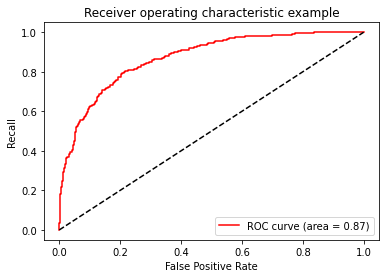

In [277]:
from sklearn.metrics import roc_curve as ROC
import matplotlib.pyplot as plt
FPR, Recall, thresholds = ROC(Ytest,clf.decision_function(Xtest),pos_label=1)
area = roc_auc_score(Ytest,clf.decision_function(Xtest))
area
plt.figure()
plt.plot(FPR, Recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

以此模型作为基础，我们来求解最佳阈值：

In [278]:
maxindex = (Recall - FPR).tolist().index(max(Recall - FPR))
thresholds[maxindex]

-0.09027758630126459

基于我们选出的最佳阈值，我们来认为确定y_predict，并确定在这个阈值下的recall和准确度的值：

In [279]:
from sklearn.metrics import accuracy_score as AC
times = time()
clf = SVC(kernel = "linear",C=3.1663157894736838,cache_size = 2000
         ,class_weight = "balanced"
         ).fit(Xtrain, Ytrain)

prob = pd.DataFrame(clf.decision_function(Xtest))

In [284]:
prob.head()

,0,y_pred
0,2.186028,1.0
1,0.373602,1.0
2,-0.019583,1.0
3,-1.134845,0.0
4,-0.237963,0.0


In [281]:
prob.loc[prob.iloc[:,0] >= thresholds[maxindex],"y_pred"]=1
prob.loc[prob.iloc[:,0] < thresholds[maxindex],"y_pred"]=0

In [285]:
prob.head()

,0,y_pred
0,2.186028,1.0
1,0.373602,1.0
2,-0.019583,1.0
3,-1.134845,0.0
4,-0.237963,0.0


In [283]:
prob.loc[:,"y_pred"].isnull().sum()

0

In [286]:
#检查模型本身的准确度
score = AC(Ytest,prob.loc[:,"y_pred"].values)
recall = recall_score(Ytest, prob.loc[:,"y_pred"])
print("testing accuracy %f,recall is %f" % (score,recall))
print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

testing accuracy 0.790000,recall is 0.804665
02:59:589272


反而还不如我们不调整时的效果好。可见，如果我们追求平衡，那SVC本身的结果就已经非常接近最优结果了。调
节阈值，调节参数C和调节class_weight都不一定有效果。但整体来看，我们的模型不是一个糟糕的模型，但这个
结果如果提交到kaggle参加比赛是绝对不足够的。如果大家感兴趣，还可以更加深入地探索模型，或者换别的方法
来处理特征，以达到AUC面积0.9以上，或是准确度或recall都提升到90%以上。

### 4.6 SVM总结&结语

在两周的学习中，我们逐渐探索了SVC在sklearn中的全貌，我们学习了SVM原理，包括决策边界，损失函数，拉格
朗日函数，拉格朗日对偶函数，软间隔硬间隔，核函数以及核函数的各种应用。我们了解了SVC类的各种重要参
数，属性和接口，其中参数包括软间隔的惩罚系数C，核函数kernel，核函数的相关参数gamma，coef0和
degree，解决样本不均衡的参数class_weight，解决多分类问题的参数decision_function_shape，控制概率的参
数probability，控制计算内存的参数cache_size，属性主要包括调用支持向量的属性support_vectors_和查看特征
重要性的属性coef_。接口中，我们学习了最核心的decision_function。除此之外，我们介绍了分类模型的模型评
估指标：混淆矩阵和ROC曲线，还介绍了部分特征工程和数据预处理的思路。<br>
<br>
支持向量机是深奥并且强大的模型，我们还可以在很多地方继续进行探索，能够学到这里的大家都非常棒！希望大
家再接再厉，掌握好这个强大的算法，后面的学习中继续加油。

注：截图来源于B站菜菜的sklearn教学。